This file is used for patient-level aggregation. Here we use SVM to train and classify the patients' patch-level probability histogram.

In [2132]:
import torch
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import torch.nn as nn
from sklearn import preprocessing
import math
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,f1_score,balanced_accuracy_score
from sklearn import linear_model
from sklearn import svm,decomposition
#The files here is in folder /MAg/datasets/,Please note that the histogram-based training set, test set, 
#and validation set of each model will be placed in the same folder, for example, placed in /MAg/datasets/CRC_DX/resnet18/
dataset = load_workbook(path_to_train_features,data_only=True)
dataset_x = dataset.active
dataset_test = load_workbook(path_to_test_features,data_only=True)
dataset_tst = dataset_test.active
validation = load_workbook(path_to_validation_features,data_only=True)
val_tst = validation.active
# number_train_MSS = load_workbook('D:/dataset_Huo_1/number/image_num_train_MSS.xlsx',data_only=True)
# num_train_MSS = number_train_MSS.active
# number_train_MSI = load_workbook('D:/dataset_Huo_1/number/image_num_train_MSI.xlsx',data_only=True)
# num_train_MSI = number_train_MSI.active
# number_val_MSS = load_workbook('D:/dataset_Huo_1/number/image_num_val_MSS.xlsx',data_only=True)
# num_val_MSS = number_val_MSS.active
# number_val_MSI = load_workbook('D:/dataset_Huo_1/number/image_num_val_MSI.xlsx',data_only=True)
# num_val_MSI = number_val_MSI.active
# number_test_MSS = load_workbook('D:/dataset_Huo_1/number/image_num_test_MSS.xlsx',data_only=True)
# num_test_MSS = number_test_MSS.active
# number_test_MSI = load_workbook('D:/dataset_Huo_1/number/image_num_test_MSI.xlsx',data_only=True)
# num_test_MSI = number_test_MSI.active
# MSI_train_other_info = load_workbook('D:/dataset_Huo_4/MSIMUT_train.xlsx',data_only=True)
# MSI_train_other_inf = MSI_train_other_info.active
# MSS_train_other_info = load_workbook('D:/dataset_Huo_4/MSS_train.xlsx',data_only=True)
# MSS_train_other_inf = MSS_train_other_info.active
# MSI_test_other_info = load_workbook('D:/dataset_Huo_4/MSIMUT_test.xlsx',data_only=True)
# MSI_test_other_inf = MSI_test_other_info.active
# MSS_test_other_info = load_workbook('D:/dataset_Huo_4/MSS_test.xlsx',data_only=True)
# MSS_test_other_inf = MSS_test_other_info.active
# MSI_val_other_info = load_workbook('D:/dataset_Huo_4/MSIMUT_validation.xlsx',data_only=True)
# MSI_val_other_inf = MSI_val_other_info.active
# MSS_val_other_info = load_workbook('D:/dataset_Huo_4/MSS_validation.xlsx',data_only=True)
# MSS_val_other_inf = MSS_val_other_info.active
dimension = 10 # the dimensions of the histogram

In [2133]:
# num_train = []
# num_val = []
# num_test = []
# for i in range(160):
#     num_train.append(num_train_MSS.cell(i+1,1).value)
# for j in range(28):
#     num_train.append(num_train_MSI.cell(j+1,1).value)
# for a in range(61):
#     num_val.append(num_val_MSS.cell(a+1,1).value)
# for b in range(11):
#     num_val.append(num_val_MSI.cell(b+1,1).value)
# for a in range(74):
#     num_test.append(num_test_MSS.cell(a+1,1).value)
# for b in range(26):
#     num_test.append(num_test_MSI.cell(b+1,1).value)

In [2134]:
# train_gender = []
# train_age = []
# test_gender = []
# test_age = []
# val_gender = []
# val_age = []
# for i in range(101):
#     train_gender.append(MSS_train_other_inf.cell(2,i+1).value)
#     train_age.append(MSS_train_other_inf.cell(3,i+1).value)
# for j in range(23):
#     train_gender.append(MSI_train_other_inf.cell(2,j+1).value)
#     train_age.append(MSI_train_other_inf.cell(3,j+1).value)
# for a in range(74):
#     test_gender.append(MSS_test_other_inf.cell(2,a+1).value)
#     test_age.append(MSS_test_other_inf.cell(3,a+1).value)
# for b in range(25):
#     test_gender.append(MSI_test_other_inf.cell(2,b+1).value)
#     test_age.append(MSI_test_other_inf.cell(3,b+1).value)
# for a in range(49):
#     val_gender.append(MSS_val_other_inf.cell(2,a+1).value)
#     val_age.append(MSS_val_other_inf.cell(3,a+1).value)
# for b in range(12):
#     val_gender.append(MSI_val_other_inf.cell(2,b+1).value)
#     val_age.append(MSI_val_other_inf.cell(3,b+1).value)

In [2135]:
#Here the files named path_to_the_counting_baseline_result is in the folder /MAg/results/counting_baseline_results/
info = openpyxl.load_workbook(path_to_the_counting_baseline_result,data_only=True)
# info = openpyxl.load_workbook('D:/dataset_Huo_1/MSS.xlsx')
sheet = info['method2-2']
pred1 = []
pred_msi = []
pred_mss = []
for j in range(74):
    pred1.append(sheet["D%d" % (j+1)].value)
    pred_mss.append(sheet["D%d" % (j+1)].value)
for i in range(25):
    pred1.append(sheet["B%d" % (i+1)].value)
    pred_msi.append(sheet["B%d" % (i+1)].value)
# print(pred1)

In [2136]:
pred_label_1 = []

for j in range(74):
    if sheet["D%d" % (j+1)].value < 0.5:
        pred_label_1.append(0)
    if sheet["D%d" % (j+1)].value >= 0.5:
        pred_label_1.append(1)
        
for i in range(25):
    if sheet["B%d" % (i+1)].value < 0.5:
        pred_label_1.append(0)
    if sheet["B%d" % (i+1)].value >= 0.5:
        pred_label_1.append(1)


In [2137]:
'''
create the training set, validation set, test set in patient level.
'''
# pca = decomposition.PCA(n_components=3,whiten=True)
X = [[0]*10 for i in range(124)]
y = []
for i in range(124):
    for j in range(10):
        X[i][j] = dataset_x.cell(i+1,j+1).value
    # X[i][10] = train_gender[i]
    # X[i][11] = train_age[i] / max(train_age)
    y.append(float(dataset_x.cell(i+1,12).value))
# X = pd.DataFrame(X)
# mean_data = X.mean()
# std_data = X.std()
# X= (X-X.mean())/X.std()
# X = np.array(X)
# X = pca.fit_transform(np.array(X))


X_val = [[0]*dimension for i in range(61)]
y_val = []
for i in range(61):
    for j in range(10):
        X_val[i][j] = val_tst.cell(i+1,j+1).value 
    # X_val[i][10] = val_gender[i]
    # X_val[i][11] = val_age[i] / max(val_age)
    y_val.append(float(val_tst.cell(i+1,12).value))
# X_val = np.array(X_val)
# X_val = pca.fit_transform(np.array(X_val))
# X_val = pd.DataFrame(X_val)
# X_val = (X_val-mean_data)/std_data
# X_val = np.array(X_val)
# X_val = preprocessing.scale(np.array(X_val))

X_test = [[0]*dimension for i in range(99)]
y_test = []
for i in range(99):
    for j in range(10):
        X_test[i][j] = dataset_tst.cell(i+1,j+1).value 
    # X_test[i][10] = test_gender[i]
    # X_test[i][11] = test_age[i] / max(test_age)
    y_test.append(float(dataset_tst.cell(i+1,12).value))
# X_test = np.array(X_test)
# X_test = pca.fit_transform(np.array(X_test))
# X_test = pd.DataFrame(X_test)
# X_test = (X_test-mean_data)/std_data
# X_test = np.array(X_test)
# X_test = preprocessing.scale(np.array(X_test))

true_val_label = []
for j in range(49):
    true_val_label.append(0)
for i in range(12):
    true_val_label.append(1)
    
true_label = []
for j in range(74):
    true_label.append(0)
for i in range(25):
    true_label.append(1)

In [2138]:
'''
the SVM we used
'''
# clt = linear_model.LogisticRegression(penalty='l2',C=0.5,class_weight = {0:0.179,1:0.821},solver = 'liblinear')
clt = svm.SVC(C = 5,kernel = 'rbf',probability = True,class_weight = {0:0.0061,1:0.9939})
clt.fit(X,y)
test = [[]]

pred_label_val = clt.predict(X_val)
# print(label)
right_mss = 0
right_msi = 0
for k in range(49):
    if pred_label_val[k] == 0:
        right_mss = right_mss + 1
for k in range(12):
    if pred_label_val[k + 49] == 1:
        right_msi = right_msi + 1
print('right mss:',right_mss,'/ 49')
print('right msi:',right_msi,'/ 12')
print('f1_val:',f1_score(true_val_label,pred_label_val))
print('acc:', right_mss + right_msi,'/ 61')
print('acc:', (right_mss + right_msi) / 61)


right mss: 45 / 49
right msi: 8 / 12
f1_val: 0.6666666666666666
acc: 53 / 61
acc: 0.8688524590163934


In [2139]:
'''
test the trained SVM model
'''
pred_label_test = clt.predict(X_test)
# print(label)
right_mss = 0
right_msi = 0
for k in range(74):
    if pred_label_test[k] == 0:
        right_mss = right_mss + 1
for k in range(25):
    if pred_label_test[k + 74] == 1:
        right_msi = right_msi + 1
f1 = f1_score(true_label,pred_label_test)
print('right mss:',right_mss,'/ 74')
print('right msi:',right_msi,'/ 25')
print('f1:',f1)
print('acc:', right_mss + right_msi,'/ 99')
print('acc:', (right_mss + right_msi) / 99)

right mss: 57 / 74
right msi: 16 / 25
f1: 0.5517241379310344
acc: 73 / 99
acc: 0.7373737373737373


In [2140]:
pred_test = []
for i in range(99):
    test[0] = X_test[i]
    pred_buf = clt.predict_proba(test)
    pred_test.append(pred_buf[0][1])
auc_score = roc_auc_score(true_label,pred_test)
print(auc_score)

0.7302702702702704


In [2141]:
print( "f1_score_before",f1_score(true_label, pred_label_1) ,'balanced score before:',balanced_accuracy_score(true_label, pred_label_1))
print( "f1_score_after", f1_score(true_label, pred_label_test),'balanced score after:',balanced_accuracy_score(true_label, pred_label_test))

f1_score_before 0.576271186440678 balanced score before: 0.7251351351351352
f1_score_after 0.5517241379310344 balanced score after: 0.7051351351351351


0.7591891891891892
0.7302702702702704


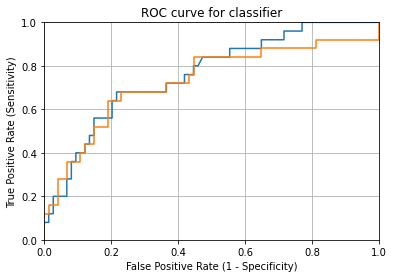

In [2142]:
fpr,tpr,thresholds = roc_curve(true_label,pred1,pos_label=1)
fpr2,tpr2,thresholds2 = roc_curve(true_label,pred_test,pos_label=1)
plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(auc(fpr, tpr))
print(auc(fpr2, tpr2))